<a href="https://colab.research.google.com/github/HakureiPOI/Modeling_Allowance/blob/main/GSA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

In [2]:
class GravitationalSearchAlgorithm():
    def __init__(self, obj_function, dim, bounds, num_agents=512, max_iter=100, g0=0.8, alpha=2, minimize=True):
        """
        初始化引力搜索算法（GSA）

        参数：
        - obj_function: 目标函数，需要最小化
        - dim: 问题的维度。
        - bounds: 每个维度的边界，格式为 [(lower_bound1, upper_bound1), ...]。
        - num_agents: 粒子（解）的数量
        - max_iter: 最大迭代次数
        - g0: 初始引力常数
        - alpha: 引力常数的动态调整参数，控制其衰减速度
        - minimize: 是否最小化目标函数（默认为True）
        """
        self.obj_function = obj_function
        self.dim = dim
        self.bounds = bounds
        self.num_agents = num_agents
        self.max_iter = max_iter
        self.g0 = g0
        self.alpha = alpha
        self.minimize = minimize

        # 设置随机数种子
        np.random.seed(42)

        # 初始化粒子的位置和速度
        self.positions = np.random.uniform(0, 1, (num_agents, dim))
        for i in range(dim):
            lower, upper = bounds[i]
            self.positions[:, i] = lower + self.positions[:, i] * (upper - lower)
        self.velocities = np.zeros((num_agents, dim))
        self.best_position = None
        self.best_score = float('inf')
        self.history = []

    def _evaluate_fitness(self):
        """评估每个粒子的适应度（目标函数值）"""
        fitness = np.array([self.obj_function(pos) for pos in self.positions])
        return fitness if self.minimize else -fitness

    def _update_gravitational_constant(self, iteration):
        """动态调整引力常数，使得最后能缓慢收敛"""
        return self.g0 * (1 - iteration / self.max_iter) ** self.alpha

    def _calculate_masses(self, fitness):
        """根据适应度计算每个粒子的质量，适配最小化问题"""
        worst = max(fitness)
        best = min(fitness)
        if best == worst:
            masses = np.ones_like(fitness)
        else:
            # 使用反向差值
            masses = (worst - fitness) / (worst - best + 1e-10)
        return masses / masses.sum()

    def _calculate_forces(self, masses, g):
        """矢量化计算作用在每个粒子上的引力"""
        forces = np.zeros((self.num_agents, self.dim))
        for i in range(self.num_agents):
            distances = np.linalg.norm(self.positions - self.positions[i], axis=1) + 1e-10
            directions = self.positions - self.positions[i]
            forces[i] = np.sum(
                g * masses[i] * masses[:, np.newaxis] / distances[:, np.newaxis] * directions,
                axis=0
            )
        return forces

    def _update_positions_and_velocities(self, forces, masses):
        """更新粒子的位置和速度"""
        accelerations = forces / (masses[:, np.newaxis] + 1e-10)
        self.velocities = np.random.rand(self.num_agents, self.dim) * self.velocities + accelerations
        self.positions += self.velocities

        # 应用边界约束
        for i in range(self.dim):
            lower, upper = self.bounds[i]
            self.positions[:, i] = np.clip(self.positions[:, i], lower, upper)

    def optimize(self):
        """运行优化过程"""
        flag = 3    # 提前收敛窗口

        for iteration in range(self.max_iter):
            # 第一步：评估适应度
            fitness = self._evaluate_fitness()

            # 更新全局最优解
            best_fitness_idx = np.argmin(fitness)
            if fitness[best_fitness_idx] < self.best_score:
                self.best_score = fitness[best_fitness_idx]
                self.best_position = self.positions[best_fitness_idx].copy()

            self.history.append(self.best_score)

            # 检测提前收敛条件
            if iteration > 0 and abs(self.history[-1] - self.history[-2]) < 1e-10:
                flag -= 1
                if flag == 0:
                    print(f"优化在第 {iteration + 1} 代提前收敛，当前最优适应度: {self.best_score}")
                    break
            else:
                flag = 3


            # 第二步：更新引力常数
            g = self._update_gravitational_constant(iteration)

            # 第三步：计算质量
            masses = self._calculate_masses(fitness)

            # 第四步：计算引力
            forces = self._calculate_forces(masses, g)

            # 第五步：更新位置和速度
            self._update_positions_and_velocities(forces, masses)

            print(f"第 {iteration + 1}/{self.max_iter} 代, 当前最优适应度: {self.best_score}")

        return self.best_position, self.best_score

    def plot_optimization_history(self):
        sns.set(style="whitegrid")
        plt.figure(figsize=(10, 6))
        plt.plot(self.history, label="Best Fitness", color="b")
        plt.xlabel("Iteration")
        plt.ylabel("Best Fitness")
        plt.title("Optimization History")
        plt.legend()
        plt.show()

    def visualize_positions(self):
        """可视化粒子的二维分布"""

        # 使用t-SNE将位置降维到2维
        tsne = TSNE(n_components=2, random_state=42)
        positions_2d = tsne.fit_transform(self.positions)

        # 绘制散点图
        sns.set(style="whitegrid")
        plt.figure(figsize=(8, 6))
        plt.scatter(positions_2d[:, 0], positions_2d[:, 1], s=20, alpha=0.7)
        plt.xlabel("Dimension 1")
        plt.ylabel("Dimension 2")
        plt.title("Particle Distribution (t-SNE)")
        plt.show()

In [3]:
def complex_function(x):
    # x 是目标函数的变量列表
    return sum((1 - x[:-1])**2 + 100 * (x[1:] - x[:-1]**2)**2)

In [4]:
dim = 10
bounds = [(-5, 5)] * dim  # 每个维度不同的边界
gsa = GravitationalSearchAlgorithm(obj_function=complex_function, dim=dim, bounds=bounds)

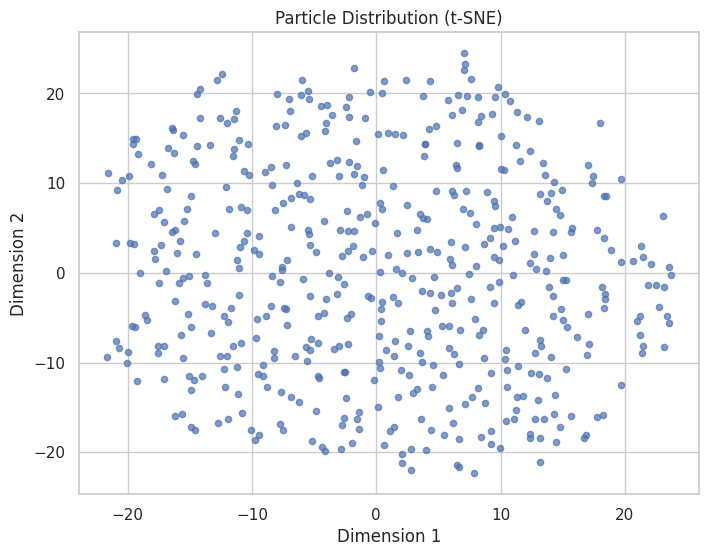

In [5]:
gsa.visualize_positions()

In [6]:
best_position, best_score = gsa.optimize()

第 1/100 代, 当前最优适应度: 12583.21442006841
第 2/100 代, 当前最优适应度: 8975.03600349496
第 3/100 代, 当前最优适应度: 4386.154050836088
第 4/100 代, 当前最优适应度: 1383.5029375869963
第 5/100 代, 当前最优适应度: 673.5098297150311
第 6/100 代, 当前最优适应度: 355.0984567130368
第 7/100 代, 当前最优适应度: 138.17893393443202
第 8/100 代, 当前最优适应度: 44.81950050524922
第 9/100 代, 当前最优适应度: 21.68565172405412
第 10/100 代, 当前最优适应度: 18.294493491448815
第 11/100 代, 当前最优适应度: 12.520026145134988
第 12/100 代, 当前最优适应度: 12.520026145134988
第 13/100 代, 当前最优适应度: 12.520026145134988
优化在第 14 代提前收敛，当前最优适应度: 12.520026145134988


In [7]:
print(f"最优位置: {best_position}")
print(f"最优适应度: {best_score}")
print(f"质点系重心：{np.mean(gsa.positions, axis=0)}")

最优位置: [-0.32170316  0.11661726  0.06167914 -0.06764868 -0.03028085  0.08152075
 -0.04419893 -0.08120396 -0.00750199 -0.05406392]
最优适应度: 12.520026145134988
质点系重心：[-0.25689849  0.16630219  0.02690593 -0.05572693  0.04517354  0.22361177
 -0.08999586 -0.24485499  0.04686931 -0.0449065 ]


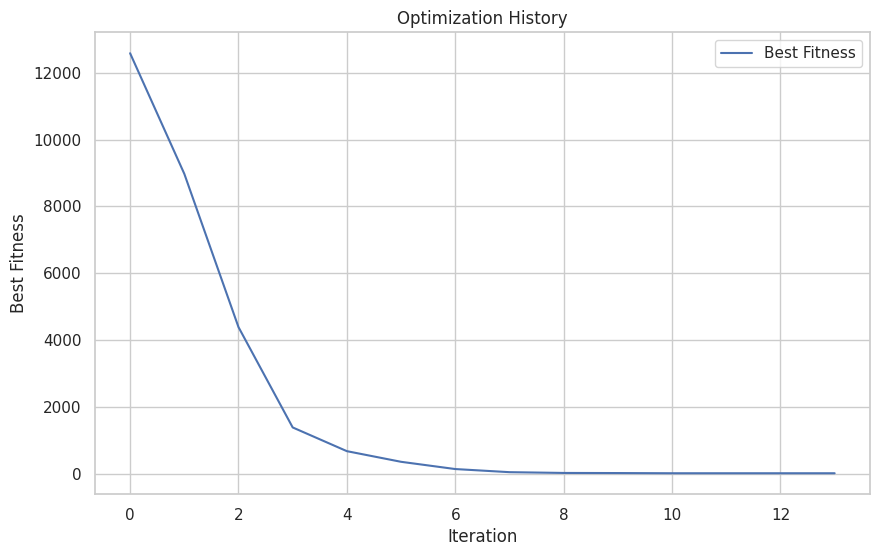

In [8]:
gsa.plot_optimization_history()

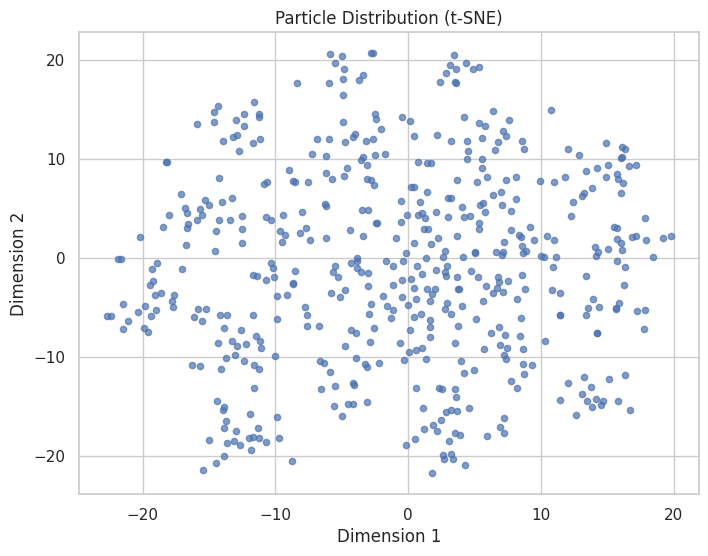

In [9]:
gsa.visualize_positions()